In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import BatchNormalization

# Data Preprocessing and Visualization

In [62]:
#load the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [63]:
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_train_names = pd.Series(y_train.flatten()).apply(lambda x: class_names[x])
y_train_names

0         frog
1        truck
2        truck
3         deer
4          car
         ...  
49995     bird
49996     frog
49997    truck
49998      car
49999      car
Length: 50000, dtype: object

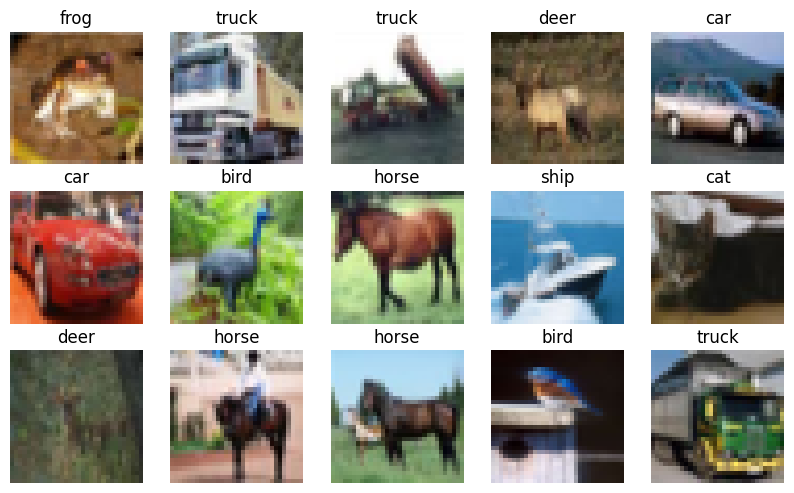

In [64]:
#Visualize first 15 samples
plt.figure(figsize = (10,10))
for i in range (15):
  grid = plt.subplot(5, 5, i+1)
  plt.imshow(x_train[i])
  plt.title(y_train_names[i])
  plt.axis('off')

plt.show()

In [65]:
#Normalization and  One-hot encode the class labels
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# CNN model 

In [66]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_29 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 activation_30 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 15, 15, 32)        0         
                                                      

In [67]:
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate = 0.0001, weight_decay=1e-6), metrics=['accuracy'])

# Image Processing

In [68]:
#Adding modified images to the training dataset
datagen = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True)
datagen.fit(x_train)

In [69]:
#Adding early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights = True)
# Saving the history to visualize the fitting process
history = model.fit(datagen.flow(x_train, y_train, batch_size=50), 
                   steps_per_epoch=x_train.shape[0] // 50,
                   epochs=100,
                   validation_data=(x_test, y_test),
                   verbose=1,
                   callbacks=[early_stop])

Epoch 1/100
1000/1000 [==============================] - 87s 85ms/step - loss: 1.8627 - accuracy: 0.3146 - val_loss: 1.5590 - val_accuracy: 0.4338
Epoch 2/100
1000/1000 [==============================] - 89s 89ms/step - loss: 1.5891 - accuracy: 0.4178 - val_loss: 1.4010 - val_accuracy: 0.4903
Epoch 3/100
1000/1000 [==============================] - 91s 91ms/step - loss: 1.4860 - accuracy: 0.4598 - val_loss: 1.3388 - val_accuracy: 0.5124
Epoch 4/100
1000/1000 [==============================] - 89s 89ms/step - loss: 1.4163 - accuracy: 0.4879 - val_loss: 1.2337 - val_accuracy: 0.5626
Epoch 5/100
1000/1000 [==============================] - 87s 87ms/step - loss: 1.3571 - accuracy: 0.5111 - val_loss: 1.2025 - val_accuracy: 0.5696
Epoch 6/100
1000/1000 [==============================] - 88s 88ms/step - loss: 1.3098 - accuracy: 0.5317 - val_loss: 1.1513 - val_accuracy: 0.5952
Epoch 7/100
1000/1000 [==============================] - 88s 88ms/step - loss: 1.2602 - accuracy: 0.5500 - val_loss: 1

In [70]:
# Evaluation

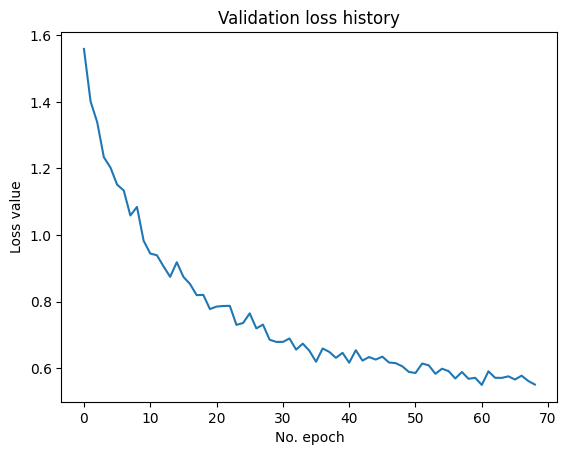

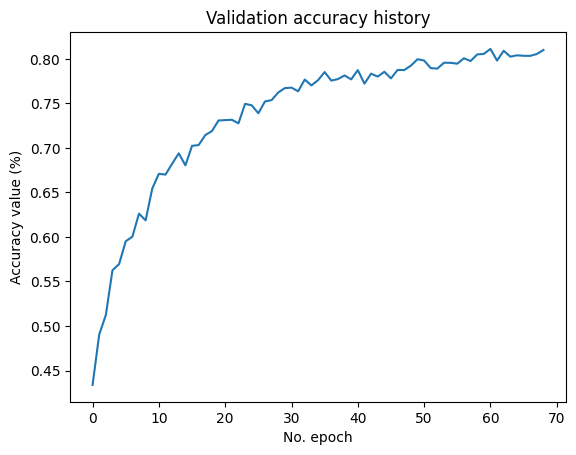

In [71]:
#Plotting Validation Loss and Accuracy History
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [72]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5493443608283997 / Test accuracy: 0.8112999796867371


In [73]:
from tensorflow.keras.models import load_model
model.save('cifar_cnn.keras')